
# EMNIST **byclass** — современный эффективный pipeline (ConvNeXtV2 + сильный рецепт обучения)

Этот ноутбук обучает точную и сравнительно быструю модель на **EMNIST (variant: byclass, 62 класса)** с использованием современных практик:
- **ConvNeXtV2-Tiny** (по умолчанию) c `timm`, предварительно обученная на ImageNet — автоматически адаптируется под 1 канал;
- **AMP (FP16)** на CUDA, `torch.compile`, **EMA** весов, **Label Smoothing**, **Mixup/CutMix**, **Random Erasing**;
- **Cosine LR** с **warmup**, **gradient clipping**, `channels_last`;
- Валидационный сплит, **лучший чекпоинт**, финальная оценка на **test**;
- Корректная ориентация EMNIST (поворот -90° + горизонтальное отражение).
  
> По умолчанию рецепты сбалансированы под accuracy / скорость. При желании можно усилить аугментации, разрешение и длину обучения в блоке конфигурации.


In [1]:
# %pip install ipynb

In [2]:

import os, math, time, copy, random
from dataclasses import dataclass
from typing import Tuple, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader, random_split, Subset, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
from IPython.display import clear_output
from torch.utils.data import Dataset
import torchvision

import matplotlib.pyplot as plt
import numpy as np

import timm
from timm.data import Mixup
from timm.loss import SoftTargetCrossEntropy, LabelSmoothingCrossEntropy

from torchmetrics.classification import MulticlassAccuracy

In [3]:
from ipynb.fs.full._3_prepare_tracked_datasets import Char,Poly,Point,CustomUnpickler

0
None
0
None
0


In [4]:
CURRENT_FOLDER="./"
DATASET_VARIANT="byclass"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
f_train_dict= open(os.path.join(CURRENT_FOLDER,'train_dict_UJI.p'), 'rb')
f_test_dict= open(os.path.join(CURRENT_FOLDER,'test_dict_UJI.p'), 'rb')
TRAIN_DICT = CustomUnpickler(f_train_dict).load()
TEST_DICT = CustomUnpickler(f_test_dict).load()
f_train_dict.close()
f_test_dict.close()

In [6]:
# print(TRAIN_DICT)
# print(TEST_DICT)
CHAR_LIST=list(TRAIN_DICT.keys())
CHAR_LIST.sort()
print("Классов: {}".format(len(list(TRAIN_DICT.keys()))))
print(list(TRAIN_DICT.keys()).sort())
all_size=0
for key in TRAIN_DICT.keys():
  all_size+=len(TRAIN_DICT[key])

Классов: 62
None


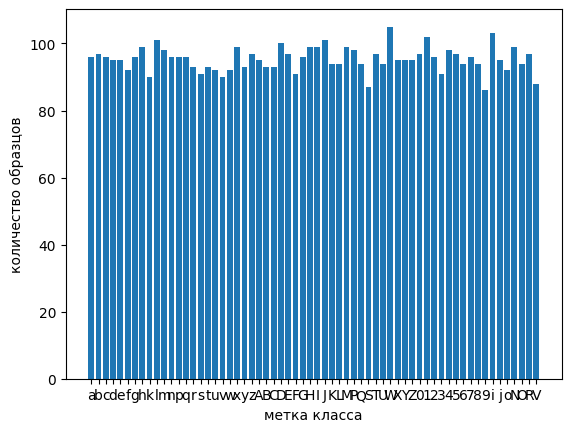

In [7]:
plt.bar( TRAIN_DICT.keys(),[len(TRAIN_DICT[key]) for key in TRAIN_DICT.keys()])
plt.xlabel("метка класса")
plt.ylabel("количество образцов")
plt.savefig("images/uji_dataset.png",  bbox_inches='tight', pad_inches=0)

In [8]:

# %%capture
# Установим зависимости (если нужно). В Colab / локально с CUDA это обычно достаточно.
# Перезапуск среды НЕ требуется.
import sys, subprocess, pkgutil
def pip_install(pkg):
    if pkg not in {m.name for m in pkgutil.iter_modules()}:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

for p in ["timm", "torchmetrics"]:
    pip_install(p)

print("✅ Зависимости готовы.")


✅ Зависимости готовы.


In [9]:


# Device
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

# Repro
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(42)


Device: cuda


In [10]:

@dataclass
class CFG:
    data_dir: str = "./data"
    split: str = "byclass"       # ВАЖНО: вариант EMNIST
    num_classes: int = 62        # byclass = 62 класса
    img_size: int = 96          # Можно 96/128/160/192/224; 128 — быстрый и точный компромисс
    batch_size: int = 512        # Подберите под вашу GPU (например, 256/384/512/...)
    num_workers: int = 4
    val_ratio: float = 0.05
    epochs: int = 200             # Увеличьте до 20-40 для максимума качества
    lr: float = 1e-3             # базовый LR под AdamW (будет warmup + cosine)
    weight_decay: float = 0.05
    warmup_steps_ratio: float = 0.03  # доля шагов тренировок на линейный warmup
    min_lr_ratio: float = 0.05        # последний LR = lr * min_lr_ratio
    grad_clip_norm: float = 2.0
    label_smoothing: float = 0.07
    mixup_alpha: float = 0.2         # 0.0 = выкл; 0.2–0.4 — разумно
    cutmix_alpha: float = 0.0        # можно 0.5 совместно с mixup
    random_erasing_p: float = 0.1
    weighted_sampling: bool = False   # Включите, если замечаете дисбаланс
    ema_decay: float = 0.9997
    use_compile: bool = True
    model_name: str = "convnextv2_tiny"  # варианты: convnextv2_tiny / tf_efficientnetv2_s / resnet50d и др.
    in_chans: int = 1                  # 1 — серые изображения; timm умеет подкладывать веса из 3 каналов
    fix_emnist_orientation: bool = True
    show_samples: bool = True

cfg = CFG()
print(cfg)


CFG(data_dir='./data', split='byclass', num_classes=62, img_size=96, batch_size=512, num_workers=4, val_ratio=0.05, epochs=200, lr=0.001, weight_decay=0.05, warmup_steps_ratio=0.03, min_lr_ratio=0.05, grad_clip_norm=2.0, label_smoothing=0.07, mixup_alpha=0.2, cutmix_alpha=0.0, random_erasing_p=0.1, weighted_sampling=False, ema_decay=0.9997, use_compile=True, model_name='convnextv2_tiny', in_chans=1, fix_emnist_orientation=True, show_samples=True)


Train: 5618  |  Val: 295  |  Test: 1527


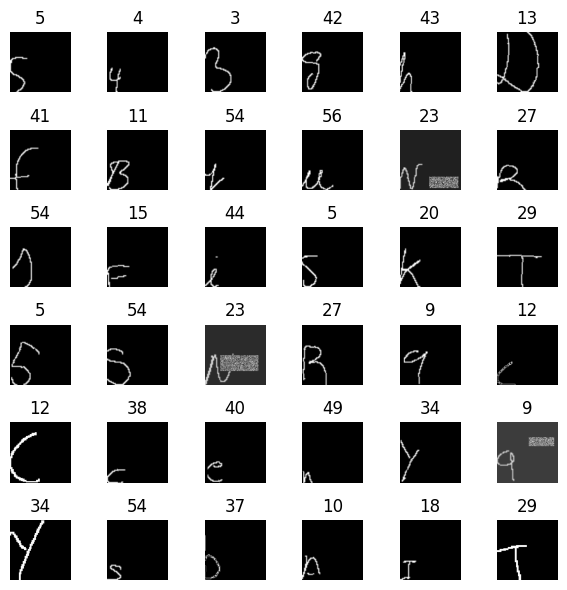

In [11]:

# EMNIST требует фикса ориентации для "читаемого" вида:
# Официальная рекомендация (см. документацию EMNIST/torchvision): повернуть -90° и отразить по горизонтали.
def fix_emnist(img):
    img = TF.rotate(img, 180)    # повернуть на -90 градусов
    img = TF.hflip(img)          # горизонтальное отражение
    return img

# Нормализация под "псевдо-ImageNet" для 1 канала: среднее и std усреднены по RGB
IMAGENET_GRAY_MEAN = (0.449,)
IMAGENET_GRAY_STD  = (0.226,)

train_tf_list = []
if cfg.fix_emnist_orientation:
    train_tf_list.append(transforms.Lambda(fix_emnist))

train_tf_list += [
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.Grayscale(num_output_channels=cfg.in_chans),  # гарантируем 1 канал
    transforms.RandAugment(num_ops=2, magnitude=3),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_GRAY_MEAN, IMAGENET_GRAY_STD),
    transforms.RandomErasing(p=cfg.random_erasing_p, scale=(0.02, 0.25), ratio=(0.3, 3.3), value="random")
]

val_tf_list = []
if cfg.fix_emnist_orientation:
    val_tf_list.append(transforms.Lambda(fix_emnist))

val_tf_list += [
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.Grayscale(num_output_channels=cfg.in_chans),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_GRAY_MEAN, IMAGENET_GRAY_STD),
]

train_transform = transforms.Compose(train_tf_list)
val_transform = transforms.Compose(val_tf_list)

class ImageDataset(Dataset):

    def __init__(self, data, transform=None):
        str="0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
        self.data=np.array([])
        for key in data.keys():
            for ch in data[key]:
                if key in str:
                    self.data=np.append(self.data,[ch])              
        self.classes=list(str)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img=self.data[idx].singleImage()
        array = np.array(img, dtype=np.uint8)
        img = Image.fromarray(array)
        if self.transform:
            img = self.transform(img)
        class_num=self.classes.index(self.data[idx].name)
        return img,class_num

image_datasets = {"train": ImageDataset(TRAIN_DICT,transform=train_transform),
                 "val":ImageDataset(TEST_DICT,transform=val_transform)}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
classes_names = {x: image_datasets[x].classes for x in ['train', 'val']}
        
train_full = image_datasets["train"]
test_set = image_datasets["val"]

n_train = len(train_full)
n_val = int(n_train * cfg.val_ratio)
n_tr  = n_train - n_val

train_set, val_set = random_split(train_full, [n_tr, n_val], generator=torch.Generator().manual_seed(42))

print(f"Train: {len(train_set)}  |  Val: {len(val_set)}  |  Test: {len(test_set)}")

# Визуализация пары сэмплов
if cfg.show_samples:
    import math
    from PIL import Image
    grid_sz = 6
    fig, axes = plt.subplots(grid_sz, grid_sz, figsize=(6,6))
    for ax in axes.ravel():
        idx = random.randrange(len(train_set))
        img, label = train_set[idx]
        # img тензор [C,H,W]; для просмотра свернём до HxW
        ax.imshow(img.squeeze().numpy(), cmap="gray")
        ax.set_title(str(label))
        ax.axis("off")
    plt.tight_layout()
    plt.show()


In [12]:
image_datasets["train"][0][0].shape

torch.Size([1, 96, 96])

In [13]:

def make_weighted_sampler(train_subset: Subset, num_classes: int) -> Optional[WeightedRandomSampler]:
    # Собираем labels именно на подмножестве train_set
    base_ds = train_subset.dataset  # это train_full (EMNIST train)
    all_targets = torch.as_tensor(base_ds.targets, dtype=torch.long)
    subset_idx = torch.as_tensor(train_subset.indices, dtype=torch.long)
    labels = all_targets.index_select(0, subset_idx)
    counts = torch.bincount(labels, minlength=num_classes).float()
    inv_freq = 1.0 / (counts + 1e-9)
    sample_weights = inv_freq[labels]
    return WeightedRandomSampler(weights=sample_weights.double(),
                                 num_samples=len(sample_weights),
                                 replacement=True)

sampler = make_weighted_sampler(train_set, cfg.num_classes) if cfg.weighted_sampling else None

train_loader = DataLoader(train_set, batch_size=cfg.batch_size,
                          shuffle=(sampler is None), sampler=sampler,
                          num_workers=cfg.num_workers, pin_memory=True, persistent_workers=True)

val_loader   = DataLoader(val_set, batch_size=cfg.batch_size*2,
                          shuffle=False, num_workers=cfg.num_workers,
                          pin_memory=True, persistent_workers=True)

test_loader  = DataLoader(test_set, batch_size=cfg.batch_size*2,
                          shuffle=False, num_workers=cfg.num_workers,
                          pin_memory=True, persistent_workers=True)

steps_per_epoch = math.ceil(len(train_loader))
total_train_steps = steps_per_epoch * cfg.epochs
warmup_steps = int(total_train_steps * cfg.warmup_steps_ratio)

print(f"Steps/epoch: {steps_per_epoch}, total steps: {total_train_steps}, warmup: {warmup_steps}")


Steps/epoch: 11, total steps: 2200, warmup: 66


In [14]:

# Создаём модель через timm и адаптируем под один канал и 62 класса.
model = timm.create_model(cfg.model_name, pretrained=True, in_chans=cfg.in_chans, num_classes=cfg.num_classes)

# Качество/скорость улучшает channels_last (на CUDA)
if device == "cuda":
    model = model.to(memory_format=torch.channels_last)

model = model.to(device)

# Опционально torch.compile для ускорения (PyTorch >= 2.0)
if cfg.use_compile:
    try:
        model = torch.compile(model)
        print("✅ torch.compile активирован")
    except Exception as e:
        print("⚠️ torch.compile не сработал:", e)

# EMA контейнер
class ModelEMA:
    def __init__(self, model: nn.Module, decay: float = 0.9997, device: Optional[str] = None):
        self.ema = copy.deepcopy(model).eval()
        for p in self.ema.parameters():
            p.requires_grad_(False)
        self.decay = decay
        self.device = device
        if device is not None:
            self.ema.to(device)

    @torch.no_grad()
    def update(self, model: nn.Module):
        d = self.decay
        msd = model.state_dict()
        for k, v in self.ema.state_dict().items():
            if v.dtype.is_floating_point:
                v.copy_(v * d + msd[k] * (1.0 - d))
            else:
                v.copy_(msd[k])

model_ema = ModelEMA(model, decay=cfg.ema_decay, device=device)

# # Оптимизатор, лосс, миксап
# optimizer = AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay, fused=(device=="cuda"))

use_mixup = (cfg.mixup_alpha > 0.0) or (cfg.cutmix_alpha > 0.0)
if use_mixup:
    mixup_fn = Mixup(mixup_alpha=cfg.mixup_alpha, cutmix_alpha=cfg.cutmix_alpha,
                     label_smoothing=cfg.label_smoothing,
                     num_classes=cfg.num_classes)
    criterion = SoftTargetCrossEntropy()
else:
    mixup_fn = None
    criterion = LabelSmoothingCrossEntropy(smoothing=cfg.label_smoothing)


# # Метрики
acc1_metric_val = MulticlassAccuracy(num_classes=cfg.num_classes, top_k=1).to(device)
acc3_metric_val = MulticlassAccuracy(num_classes=cfg.num_classes, top_k=3).to(device)
acc5_metric_val = MulticlassAccuracy(num_classes=cfg.num_classes, top_k=5).to(device)

acc1_metric_test = MulticlassAccuracy(num_classes=cfg.num_classes, top_k=1).to(device)
acc3_metric_test = MulticlassAccuracy(num_classes=cfg.num_classes, top_k=1).to(device)
acc5_metric_test = MulticlassAccuracy(num_classes=cfg.num_classes, top_k=5).to(device)

print("Модель:", cfg.model_name)


✅ torch.compile активирован
Модель: convnextv2_tiny


In [15]:
# === Patch: безопасный AdamW + современный AMP ===
import torch, torch.nn as nn
from contextlib import nullcontext
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

# 1) (Опционально, но полезно на NVIDIA) разрешим TF32 для скорости
if device == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# 2) Отключаем fused-ядро у AdamW -> избавляемся от строгих требований к dtype/layout
#    Включаем foreach (мульти-тензорный путь) — он быстрый и устойчивый.
optimizer = AdamW(
    model.parameters(),
    lr=cfg.lr,
    weight_decay=cfg.weight_decay,
    fused=False,
    foreach=True
)

# Пересоздаём scheduler с новым optimizer
cosine_scheduler = CosineAnnealingLR(
    optimizer,
    T_max=max(1, total_train_steps - warmup_steps),
    eta_min=cfg.lr * cfg.min_lr_ratio
)

# 3) Современный AMP API (без депрекейт-предупреждений)
amp_dtype = (torch.bfloat16 if (device == "cuda" and torch.cuda.is_bf16_supported()) else torch.float16)

def autocast_ctx():
    return torch.amp.autocast(device_type="cuda", dtype=amp_dtype) if device == "cuda" else nullcontext()

scaler = torch.amp.GradScaler(device="cuda", enabled=(device == "cuda"))

# 4) Переопределяем train_one_epoch c новым autocast/scaler
def train_one_epoch(epoch: int, global_step: int, scaler):
    model.train()
    running_loss = 0.0
    correct1 = 0
    total = 0
    log_every = max(1, steps_per_epoch // 100)

    for step, (x, y) in enumerate(train_loader):
        # Убедимся, что батчи тоже channels_last (немного ускоряет на CUDA)
        x = x.to(device, non_blocking=True)
        if device == "cuda":
            x = x.to(memory_format=torch.channels_last)
        y = y.to(device, non_blocking=True)

        # Mixup/CutMix
        if mixup_fn is not None:
            x, y_mix = mixup_fn(x, y)
            targets = y_mix
        else:
            targets = y

        with autocast_ctx():
            out = model(x)
            loss = criterion(out, targets)

        optimizer.zero_grad(set_to_none=True)

        if device == "cuda":
            scaler.scale(loss).backward()
            if cfg.grad_clip_norm and cfg.grad_clip_norm > 0:
                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            if cfg.grad_clip_norm and cfg.grad_clip_norm > 0:
                nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip_norm)
            optimizer.step()

        # EMA обновляем как раньше
        model_ema.update(model)

        # LR warmup + cosine
        global_step += 1
        if global_step <= warmup_steps:
            warmup_lr = cfg.lr * (global_step / max(1, warmup_steps))
            for pg in optimizer.param_groups:
                pg["lr"] = warmup_lr
        else:
            cosine_scheduler.step()

        running_loss += loss.item() * x.size(0)

        if mixup_fn is None:
            preds = out.argmax(dim=1)
            correct1 += (preds == y).sum().item()
            total += y.size(0)

        if (step + 1) % log_every == 0 or (step + 1) == steps_per_epoch:
            if mixup_fn is None and total > 0:
                approx_acc = 100.0 * correct1 / total
                print(f"Epoch {epoch+1} [{step+1}/{steps_per_epoch}]  loss={running_loss/(((step+1)*train_loader.batch_size)):.4f}  acc≈{approx_acc:5.2f}%  lr={optimizer.param_groups[0]['lr']:.5f}")
            else:
                print(f"Epoch {epoch+1} [{step+1}/{steps_per_epoch}]  loss={running_loss/(((step+1)*train_loader.batch_size)):.4f}  lr={optimizer.param_groups[0]['lr']:.5f}")

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss, global_step

print("✅ Patched: non-fused AdamW + torch.amp autocast/GradScaler (BF16 if available)")






@torch.no_grad()
def evaluate(loader, use_ema: bool = True):
    model_to_eval = model_ema.ema if use_ema else model
    model_to_eval.eval()

    total_loss = 0.0
    acc1_metric_val.reset()
    acc3_metric_val.reset()
    acc5_metric_val.reset()

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        out = model_to_eval(x)
        loss = F.cross_entropy(out, y)
        total_loss += loss.item() * x.size(0)

        acc1_metric_val.update(out, y)
        acc3_metric_val.update(out, y)
        acc5_metric_val.update(out, y)

    n = len(loader.dataset)
    val_loss = total_loss / n
    acc1 = acc1_metric_val.compute().item() * 100.0
    acc3 = acc3_metric_val.compute().item() * 100.0
    acc5 = acc5_metric_val.compute().item() * 100.0
    return val_loss, acc1, acc3, acc5

best_val_acc = 0.0
best_ckpt_path = "models/best_uji_model.pth"
best_is_ema = True

global_step = 0
print("🚀 Старт обучения")
start_time = time.time()

scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

train_history = {"epoch": [], "train_loss": [], "val_loss": [], "val_acc1": [], "val_acc3": [], "val_acc5": []}

for epoch in range(cfg.epochs):
    train_loss, global_step = train_one_epoch(epoch, global_step, scaler)
    val_loss, val_acc1, val_acc3, val_acc5 = evaluate(val_loader, use_ema=True)

    train_history["epoch"].append(epoch+1)
    train_history["train_loss"].append(train_loss)
    train_history["val_loss"].append(val_loss)
    train_history["val_acc1"].append(val_acc1)
    train_history["val_acc3"].append(val_acc3)
    train_history["val_acc5"].append(val_acc5)

    print(f"✅ Epoch {epoch+1}: val_loss={val_loss:.4f}  val_acc@1={val_acc1:.2f}%  val_acc@3={val_acc3:.2f}%  val_acc@5={val_acc5:.2f}%")

    # Сохраняем лучший чекпоинт (по валид. top-1) — EMA веса
    if val_acc1 > best_val_acc:
        best_val_acc = val_acc1
        best_is_ema = True
        torch.save(model_ema.ema.state_dict(), best_ckpt_path)
        print(f"💾 Обновлён лучший чекпоинт: {best_ckpt_path} (EMA)")

total_time = (time.time() - start_time) / 60.0
print(f"🏁 Обучение завершено. Эпох: {cfg.epochs}. Время: {total_time:.1f} мин.")

✅ Patched: non-fused AdamW + torch.amp autocast/GradScaler (BF16 if available)
🚀 Старт обучения


/tmp/ipykernel_3979/3035346702.py:150: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


Epoch 1 [1/11]  loss=4.3318  lr=0.00002
Epoch 1 [2/11]  loss=4.2410  lr=0.00003
Epoch 1 [3/11]  loss=4.2109  lr=0.00005
Epoch 1 [4/11]  loss=4.1920  lr=0.00006
Epoch 1 [5/11]  loss=4.1799  lr=0.00008
Epoch 1 [6/11]  loss=4.1714  lr=0.00009
Epoch 1 [7/11]  loss=4.1666  lr=0.00011
Epoch 1 [8/11]  loss=4.1625  lr=0.00012
Epoch 1 [9/11]  loss=4.1585  lr=0.00014
Epoch 1 [10/11]  loss=4.1558  lr=0.00015
Epoch 1 [11/11]  loss=4.1430  lr=0.00017
✅ Epoch 1: val_loss=4.2919  val_acc@1=0.56%  val_acc@3=2.78%  val_acc@5=4.67%
💾 Обновлён лучший чекпоинт: models/best_uji_model.pth (EMA)
Epoch 2 [1/11]  loss=4.1035  lr=0.00018
Epoch 2 [2/11]  loss=4.1039  lr=0.00020
Epoch 2 [3/11]  loss=4.0938  lr=0.00021
Epoch 2 [4/11]  loss=4.0747  lr=0.00023
Epoch 2 [5/11]  loss=4.0476  lr=0.00024
Epoch 2 [6/11]  loss=4.0228  lr=0.00026
Epoch 2 [7/11]  loss=3.9899  lr=0.00027
Epoch 2 [8/11]  loss=3.9858  lr=0.00029
Epoch 2 [9/11]  loss=3.9453  lr=0.00030
Epoch 2 [10/11]  loss=3.9087  lr=0.00032
Epoch 2 [11/11]  lo

/tmp/ipykernel_3979/3889338029.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("models/best_uji_model.pth", map_location=device)


📊 Test: loss=0.8224  acc@1=81.58%  acc@3=81.58%  acc@5=98.26%
💾 Сохранено: models/uji_byclass_best_ema.pth


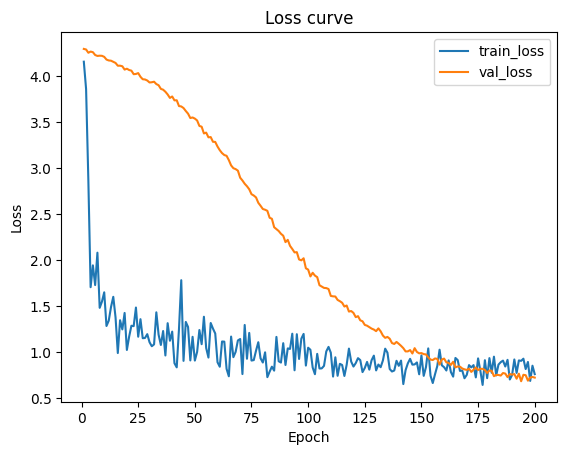

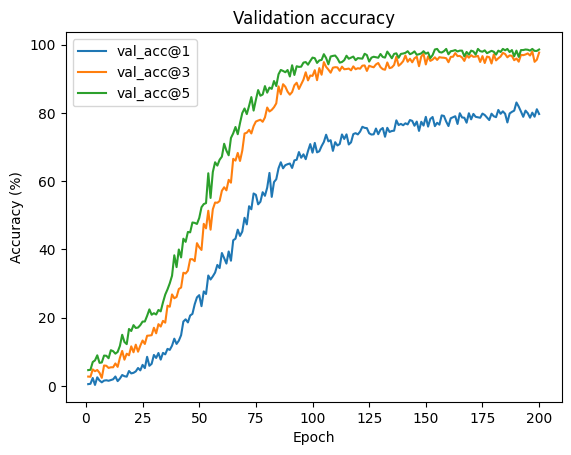

In [16]:

# Загрузка лучшего чекпоинта в EMA-модель и финальная оценка на Test
state = torch.load("models/best_uji_model.pth", map_location=device)
model_ema.ema.load_state_dict(state)

@torch.no_grad()
def evaluate_test():
    model_to_eval = model_ema.ema
    model_to_eval.eval()

    total_loss = 0.0
    acc1_metric_test.reset()
    acc3_metric_test.reset()
    acc5_metric_test.reset()

    for x, y in test_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        out = model_to_eval(x)
        loss = F.cross_entropy(out, y)
        total_loss += loss.item() * x.size(0)

        acc1_metric_test.update(out, y)
        acc3_metric_test.update(out, y)
        acc5_metric_test.update(out, y)

    n = len(test_loader.dataset)
    test_loss = total_loss / n
    test_acc1 = acc1_metric_test.compute().item() * 100.0
    test_acc3 = acc3_metric_test.compute().item() * 100.0
    test_acc5 = acc5_metric_test.compute().item() * 100.0
    return test_loss, test_acc1, test_acc3, test_acc5

test_loss, test_acc1, test_acc3, test_acc5 = evaluate_test()
print(f"📊 Test: loss={test_loss:.4f}  acc@1={test_acc1:.2f}%  acc@3={test_acc3:.2f}%  acc@5={test_acc5:.2f}%")

# Сохраняем лучший весовой файл отдельно
final_weights_path = "models/uji_byclass_best_ema.pth"
torch.save(model_ema.ema.state_dict(), final_weights_path)
print("💾 Сохранено:", final_weights_path)

# Графики (одиночный график на метрику, без seaborn, без цветов)
epochs = train_history["epoch"]
plt.figure()
plt.plot(epochs, train_history["train_loss"], label="train_loss")
plt.plot(epochs, train_history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss curve")
plt.show()

plt.figure()
plt.plot(epochs, train_history["val_acc1"], label="val_acc@1")
plt.plot(epochs, train_history["val_acc3"], label="val_acc@3")
plt.plot(epochs, train_history["val_acc5"], label="val_acc@5")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Validation accuracy")
plt.show()


In [17]:

from PIL import Image
@torch.no_grad()
def predict_image(path: str) -> Tuple[int, np.ndarray]:
    model_ema.ema.eval()
    img = Image.open(path).convert("L")  # grayscale
    if cfg.fix_emnist_orientation:
        img = fix_emnist(img)
    img = img.resize((cfg.img_size, cfg.img_size))
    x = transforms.ToTensor()(img)
    x = transforms.Normalize(IMAGENET_GRAY_MEAN, IMAGENET_GRAY_STD)(x)
    x = x.unsqueeze(0).to(device)
    logits = model_ema.ema(x)
    probs = logits.softmax(dim=1).cpu().numpy()[0]
    pred = int(probs.argmax())
    return pred, probs

print("Готово к инференсу: используйте predict_image('/path/to/img.png')")


Готово к инференсу: используйте predict_image('/path/to/img.png')
